# 2022.08.01

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch

%matplotlib inline
warnings.filterwarnings('ignore')

In [486]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [487]:
torch.cuda.get_device_name(0)
print('Device:', device)
print(torch.cuda.current_device())

Device: cuda
0


## Raw data info.

In [488]:
path = 'D:/data/새 폴더/_Noise data'
num_of_files = 1
num_of_datas = 11500

In [489]:
file_list = os.listdir(path)
file_list_py = [file for file in file_list[:num_of_files] if file.endswith('.csv')]
file_list_py

['Si_ 3 times0_1_10000_31426316.csv']

In [490]:
train = pd.DataFrame()
j = 0

for i in file_list_py:
    data = pd.read_csv(path+'/'+i,
                      skiprows=11,
                      nrows = num_of_datas,
                      header = None,
                      names =[j],
                      encoding = 'cp949'
                      )
    j = j + 1 
    train = pd.concat([train,data], axis = 1, sort=True)

In [491]:
train

,0
0,-0.016022
1,-0.013428
2,-0.010834
3,-0.008240
4,-0.003815
...,...
11495,0.026093
11496,0.026093
11497,0.028381
11498,0.025177


## Data explo.

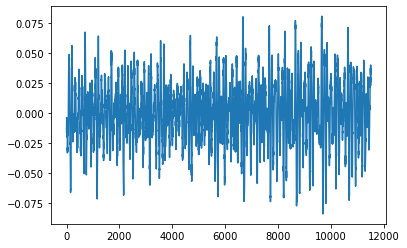

<Figure size 1440x360 with 0 Axes>

In [559]:
plt.plot(train)
plt.figure(figsize=(20, 5))
plt.show()

## Test data load

In [493]:
valid = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_15_42000.csv',
                    encoding = 'cp949', skiprows = 11, names = [0])

In [494]:
valid = valid[:11500]
valid

,0
0,-0.014648
1,-0.014343
2,-0.014038
3,-0.013733
4,-0.014496
...,...
11495,-0.026703
11496,-0.035248
11497,-0.036316
11498,-0.032654


## Data split (seq2seq)

In [495]:
seq_len = 1000
pred_len = num_of_datas - seq_len

In [496]:
def truncate(x, train_len=seq_len, test_len=1):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len +1):
        in_.append(x[i:(i+train_len)])
        out_.append(x[(i+train_len):(i+train_len+test_len)])
    return np.array(in_), np.array(out_)

In [497]:
x_train, y_train = truncate(train)
x_val, y_val = truncate(valid)

In [498]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

In [499]:
print("x_train 사이즈 : {}".format(x_train.shape))
print("y_train 사이즈 : {}".format(y_train.shape))
print("x_val 사이즈 : {}".format(x_val.shape))
print("y_val 사이즈 : {}".format(y_val.shape))


x_train 사이즈 : torch.Size([10500, 1000, 1])
y_train 사이즈 : torch.Size([10500, 1, 1])
x_val 사이즈 : torch.Size([10500, 1000, 1])
y_val 사이즈 : torch.Size([10500, 1, 1])


## Dataloader 

In [500]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [501]:
batch_size = 100


In [502]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

dataloader = DataLoader(train_dataset, 
                        batch_size=batch_size, 
                        shuffle= False)

val_dataloader = DataLoader(train_dataset, 
                            batch_size=batch_size, 
                            shuffle= False)
# len(dataloader)
# dataiter = iter(dataloader)
# data = dataiter.next()
# features, labels = data
# print(features.shape, labels.shape)

## LSTM autoencoder model

In [503]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.autograd import Variable
import pytorch_model_summary

In [504]:
seq_len = x_train.shape[1]
input_size = x_train.shape[2]
hidden_size = 128
num_layers = 1
num_classes = 1 #y_train.shape[1]


In [505]:
x_train.shape

torch.Size([10500, 1000, 1])

In [506]:
dataiter = iter(dataloader)
data = dataiter.next()
x_train, y_train = data
print(x_train.shape, y_train.shape)

torch.Size([100, 1000, 1]) torch.Size([100, 1, 1])


## Encoder

In [507]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.batch_size = batch_size
            
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True,
                            dropout = 0.3
                            )
        
        self.Dense = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):    
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device) #internal state
            
        output, (last_h, last_c) = self.lstm(x, (h_0,c_0))
        output = last_h[:,-1,:]        # out = self.relu(hn)
        # out = self.Dense(out)
        return output, last_h, last_c  
            
            

## Decoder

In [508]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
            
        self.lstm2 = nn.LSTM(input_size = hidden_size,
                             hidden_size = hidden_size,
                             num_layers = num_layers,
                             batch_first = True,
                             dropout = 0.3
                             )
        
        # self.output_layer = nn.Linear(2*self.hidden_size, num_classes)
        # self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x, last_h, last_c):    
        # x = x.repeat(1, 1)
        # hidden, cell state were recived from encoder layer
        output, (last_h2, last_c2) = self.lstm2(x, (last_h, last_c))
        output = last_h2[:,-1,:]
        return output, last_h2, last_c2
            
            

In [509]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [510]:
class RecurrentAutoencoder(nn.Module):
    
      def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(input_size, hidden_size, num_layers, num_classes, batch_size)
        self.decoder = Decoder((input_size*hidden_size), 
                               hidden_size, 
                               num_layers,
                               num_classes
                               )
        self.fc = nn.Linear(hidden_size, num_classes)
        self.TimeDistributed = TimeDistributed(self.fc)
        
        
      def forward(self, x):
         x, last_h, last_c = self.encoder(x)
         x = x.repeat(batch_size, 1, 1)   ## decoder input
         
         x, last_h2, _ = self.decoder(x, last_h, last_c) ## decoder input / hidden state / cell state
         
         return self.TimeDistributed(last_h2)

## build model

In [511]:
#################### information ##########################
# encoder input = train_x
# encoder output = output, hidden, cell

# decoder input = (x, last_hidden, last_cell) -> use only last_h and last_c for input data
                # x = [batch_size, num_feature, hidden_dim] // num_feature = 1, hidden_dim = 128
                
# decoder output = last_h2 // hidden_state[:,-1,:] (last hidden state) [num_features, batch_size, hidden_dim]

# Dense input // timedistributed = 

In [512]:
# # len(dataloader)
# dataiter = iter(dataloader)
# data = dataiter.next()
# x_train, y_train = data
# print(x_train.shape, y_train.shape)

In [513]:
model = RecurrentAutoencoder(input_size, hidden_size, num_layers, num_classes).to(device)
# print(pytorch_model_summary.summary(model, torch.zeros(x_train.shape[0],
#                                                        x_train.shape[1],
#                                                        x_train.shape[2]), show_input= True))

In [563]:
print(pytorch_model_summary.summary(model, torch.zeros(x_train.shape[0].to(device),
                                                       x_train.shape[1].to(device),
                                                       x_train.shape[2].to(device)), show_input= True))

AttributeError: 'int' object has no attribute 'to'

## model checking

In [514]:
# out= model(x_train)
# print(out.shape) 

## Traning

In [515]:
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss().to(device)

history = dict(train=[], val=[])


In [516]:
for epoch in (range(num_epochs)):
    
    train_losses = []
    val_losses = []
    i = 0
    
    for batch_idx, samples in enumerate(dataloader):
        
        # training
        model = model.train()
        
        x_train, y_train = samples
        
        x_train = x_train.to(device)
        y_train = y_train.to(device)  
  
                
                
        optimizer.zero_grad()
        pred = model(x_train.to(device))
        loss = criterion(torch.flatten(pred), torch.flatten(y_train))
        
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        
        
        #validation
        
        model = model.eval()
        
        # if i == 104:    
            
    for batch_idx, samples in enumerate(val_dataloader):
        x_val, y_val = samples
        x_val = x_val.to(device)
        y_val = y_val.to(device)    
        
        with torch.no_grad():        
            valid = model(x_val)
            loss = criterion(torch.flatten(valid), torch.flatten(y_val))
            val_losses.append(loss.item())
        
        # print(i)
        # i += 1    
        
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
                  
    history['train'].append(train_loss)
    history['val'].append(val_loss)           

    print("----------------------------------------------------------------------")
    print("Epoch : {}  //  train loss : {} //  val loss : {}".format(epoch, train_loss, val_loss))
    torch.save(model,'checkpoint/checkpoint_ep_%d.pt'%epoch)        
        
    

----------------------------------------------------------------------
Epoch : 0  //  train loss : 0.0012797460416810022 //  val loss : 4.8899875582719685e-05
----------------------------------------------------------------------
Epoch : 1  //  train loss : 2.6398842384792045e-05 //  val loss : 1.823233073775468e-05
----------------------------------------------------------------------
Epoch : 2  //  train loss : 3.578516907942858e-05 //  val loss : 8.852176820038862e-05
----------------------------------------------------------------------
Epoch : 3  //  train loss : 4.056773781312153e-05 //  val loss : 1.3619383021467088e-05
----------------------------------------------------------------------
Epoch : 4  //  train loss : 1.3039758912435944e-05 //  val loss : 1.1327060565236025e-05
----------------------------------------------------------------------
Epoch : 5  //  train loss : 3.975803178729534e-05 //  val loss : 9.589074976420739e-05
-----------------------------------------------

In [517]:
print(len(train_losses), len(val_losses))

105 105


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


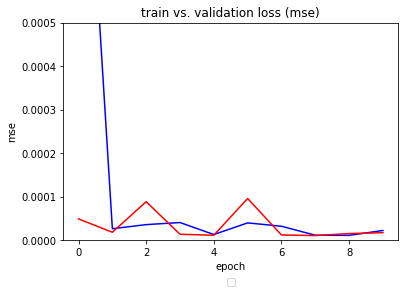

In [564]:
plt.plot(history['train'], 'b')
plt.plot(history['val'], 'r')
# plt.xlim(0, 3)
plt.ylim(0, 0.0005)
# plt.plot(history['val'], 'r')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation loss (mse)')
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)


In [537]:
model = torch.load('checkpoint/checkpoint_ep_8.pt')

## Test result (Noise only)

In [538]:
test = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_56282_180119583.csv',encoding = 'cp949', skiprows = 11, names = [0])

In [539]:
test = test[:11500]

In [540]:
kk = test[1000:]

In [541]:
X_test , y_test = truncate(test)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
KK = torch.Tensor(y_test)

TestDataset = TensorDataset(X_test, y_test)
TestLoader = DataLoader(TestDataset, 
                        batch_size=batch_size, 
                        shuffle= False)


In [542]:
x = []
for batch_idx, samples in enumerate(TestLoader):

    X_test, y_test = samples
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    test_prediction = model(X_test)
    
    y = test_prediction.cpu()
    y = y.flatten()
    y = y.detach().numpy()#.tolist()
    x.append(y)
    
    

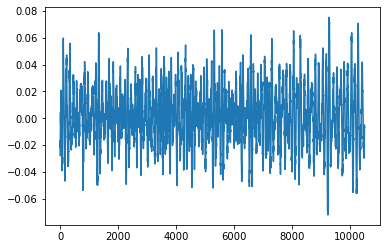

In [543]:
k =np.array(x).flatten()
# for i in range(150):
#     if i ==0:
#         k = x[0]

plt.plot(k)


(3000.0, 4000.0)

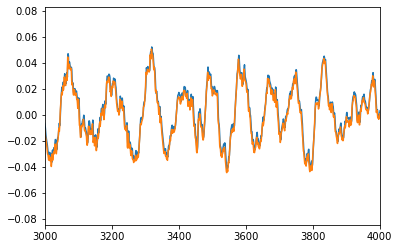

In [544]:
plt.plot(k)
plt.plot(KK.numpy().flatten())
L = 3000
plt.xlim(L,L+1000)

## Test result (Noise + friction)

In [545]:
path = 'D:/data/새 폴더/Si_#3/새 폴더'
path
from pathlib import Path
num_of_files = 0
file_list = os.listdir(path)
file_list_py = [os.path.join(path,file) for file in file_list if file.endswith('.csv')]
file_list_py = sorted(file_list_py, key=os.path.getmtime)
# file_list_py = [file for file in file_list[0:5] if file.endswith('.csv')]


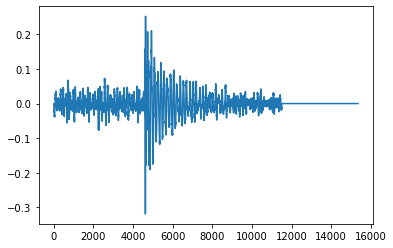

In [546]:
file_list_py

test = pd.read_csv(file_list_py[32991]
                    ,encoding = 'cp949', skiprows = 11, names = [0])
plt.plot(test)

In [547]:
test = test[:11500]

In [548]:
test = np.array(test)
X_test , y_test = truncate(test)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
KK = torch.Tensor(y_test)

In [549]:
TestDataset = TensorDataset(X_test, y_test)
TestLoader = DataLoader(TestDataset, 
                        batch_size=batch_size, 
                        shuffle= False)

In [550]:
x = []
for batch_idx, samples in enumerate(TestLoader):

    X_test, y_test = samples
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    test_prediction = model(X_test)
    
    y = test_prediction.cpu()
    y = y.flatten()
    y = y.detach().numpy()#.tolist()
    x.append(y)
    
    

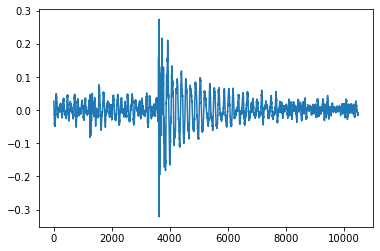

In [551]:
k =np.array(x).flatten()
# for i in range(150):
#     if i ==0:
#         k = x[0]

plt.plot(k)


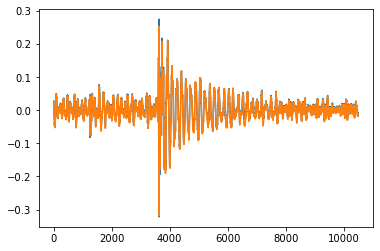

In [552]:
plt.plot(k)
plt.plot(KK.numpy().flatten())
L = 1000
# plt.xlim(L,L+1000)
